In [1]:

import json
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import joblib


In [2]:
# Sequence Length
SEQ_LEN = 240         
#  24 hours * (60 mins * 2 sample/min) = 2880
PERIOD_DAILY = 2880

In [3]:
df_initial = pd.read_csv('system-2.csv')

split_point = int(len(df_initial) * 0.7)
df = df_initial.iloc[:split_point].reset_index(drop=True) 


with open('metrics.json', 'r') as f:
    METRIC_NAMES = json.load(f)
    
COLUMNS_TO_SHOW = ['timestamp'] + METRIC_NAMES
N_FEATURES = len(METRIC_NAMES) 
print(METRIC_NAMES)

['load-15m', 'cpu-user', 'cpu-system', 'sys-fork-rate', 'sys-interrupt-rate', 'sys-context-switch-rate']


In [4]:
df.shape

(60475, 24)

In [5]:
df[COLUMNS_TO_SHOW].dtypes

timestamp                    int64
load-15m                   float64
cpu-user                   float64
cpu-system                 float64
sys-fork-rate              float64
sys-interrupt-rate         float64
sys-context-switch-rate    float64
dtype: object

In [6]:
last_timestamp_sec = df['timestamp'].iloc[-1]

df = df[COLUMNS_TO_SHOW]
print("---  first 5 rows ---")
print(df.head(5).to_markdown(index=False))


TOTAL_SECONDS_IN_DAY = 86400

total_days = last_timestamp_sec / TOTAL_SECONDS_IN_DAY

print(f"Days in dataset: {total_days:.2f} days")

---  first 5 rows ---
|   timestamp |   load-15m |   cpu-user |   cpu-system |   sys-fork-rate |   sys-interrupt-rate |   sys-context-switch-rate |
|------------:|-----------:|-----------:|-------------:|----------------:|---------------------:|--------------------------:|
|           0 |       0.16 |     0.0635 |       0.061  |            3.95 |               916.8  |                    2601.1 |
|          30 |       0.15 |     0.0585 |       0.047  |            0    |               910.45 |                    2620.2 |
|          60 |       0.16 |     0.1425 |       0.078  |            5.3  |               854.05 |                    2145.4 |
|          90 |       0.16 |     0.035  |       0.0295 |            0    |               799.35 |                    1987.8 |
|         120 |       0.17 |     0.038  |       0.0335 |            3.8  |               774.3  |                    1797.8 |
Days in dataset: 21.00 days


In [7]:
df.describe()

,timestamp,load-15m,cpu-user,cpu-system,sys-fork-rate,sys-interrupt-rate,sys-context-switch-rate
count,6.047500e+04,60475.000000,60475.000000,60475.000000,60475.000000,60475.000000,60475.000000
mean,9.071100e+05,0.075691,0.052842,0.038101,2.338041,925.513568,2360.684378
std,5.237332e+05,0.061534,0.053753,0.024756,3.288666,759.803204,1017.138032
min,0.000000e+00,0.000000,0.012000,0.013000,0.000000,656.700000,1477.300000
25%,4.535550e+05,0.020000,0.025000,0.023000,0.800000,788.400000,1904.500000
50%,9.071100e+05,0.080000,0.037500,0.030000,1.050000,848.850000,2182.750000
75%,1.360665e+06,0.110000,0.055000,0.042500,4.000000,936.750000,2601.000000
max,1.814220e+06,0.500000,1.870000,0.609000,140.350000,23107.850000,92645.050000


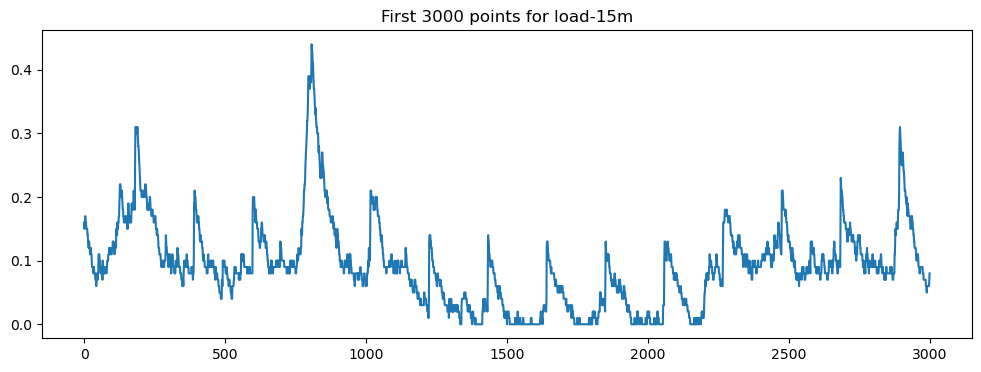

In [8]:
points_num = 3000
plt.figure(figsize=(12, 4))
plt.plot(df['load-15m'].values[:points_num]) 
plt.title(f'First {points_num} points for load-15m')
plt.show()

# Visualizing Circadian Rhythms 

In [9]:

def plot_cycle_comparison(df, target_metric, period_samples, days_to_plot, plot_mean_cycle=True):
    
    
    df_plot = df.copy()
    
    if target_metric not in df_plot.columns:
        print(f"Error: Metric '{target_metric}' not found in DataFrame.")
        return

    df_plot['time_of_cycle'] = df_plot.index % period_samples

    df_plot['day_index'] = df_plot.index // period_samples

    mean_cycle = df_plot.groupby('time_of_cycle')[target_metric].mean()

    plt.figure(figsize=(14, 7))

    sample_days = df_plot['day_index'].unique()[:days_to_plot]

    for day in sample_days:
        daily_data = df_plot[df_plot['day_index'] == day]
        
        plt.plot(daily_data['time_of_cycle'], daily_data[target_metric], 
                 alpha=0.5, linewidth=1, label=f'Cycle {day}')

    if plot_mean_cycle:
        plt.plot(mean_cycle.index, mean_cycle.values, 
                 color='red', linewidth=3, label='Average Cycle (Normal)')

    plt.title(f'Cycle Plot: {target_metric}', fontsize=16)
    plt.xlabel(f'Time of Cycle (Intervals, 0 to {period_samples-1})')
    plt.ylabel(f'Metric Value ({target_metric})')
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.legend(title='Days', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

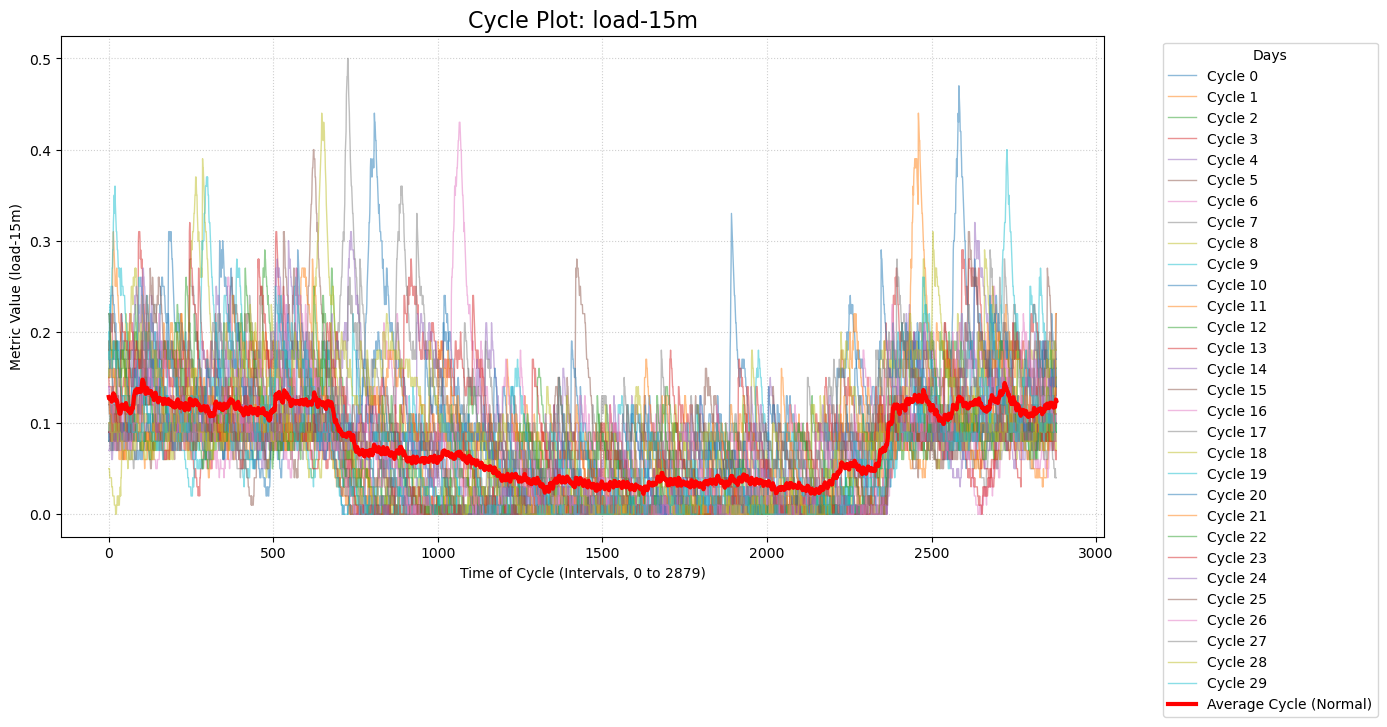

In [10]:
plot_cycle_comparison(df_initial, 
                      target_metric='load-15m', 
                      period_samples=PERIOD_DAILY, 
                      days_to_plot=30, 
                      plot_mean_cycle=True)

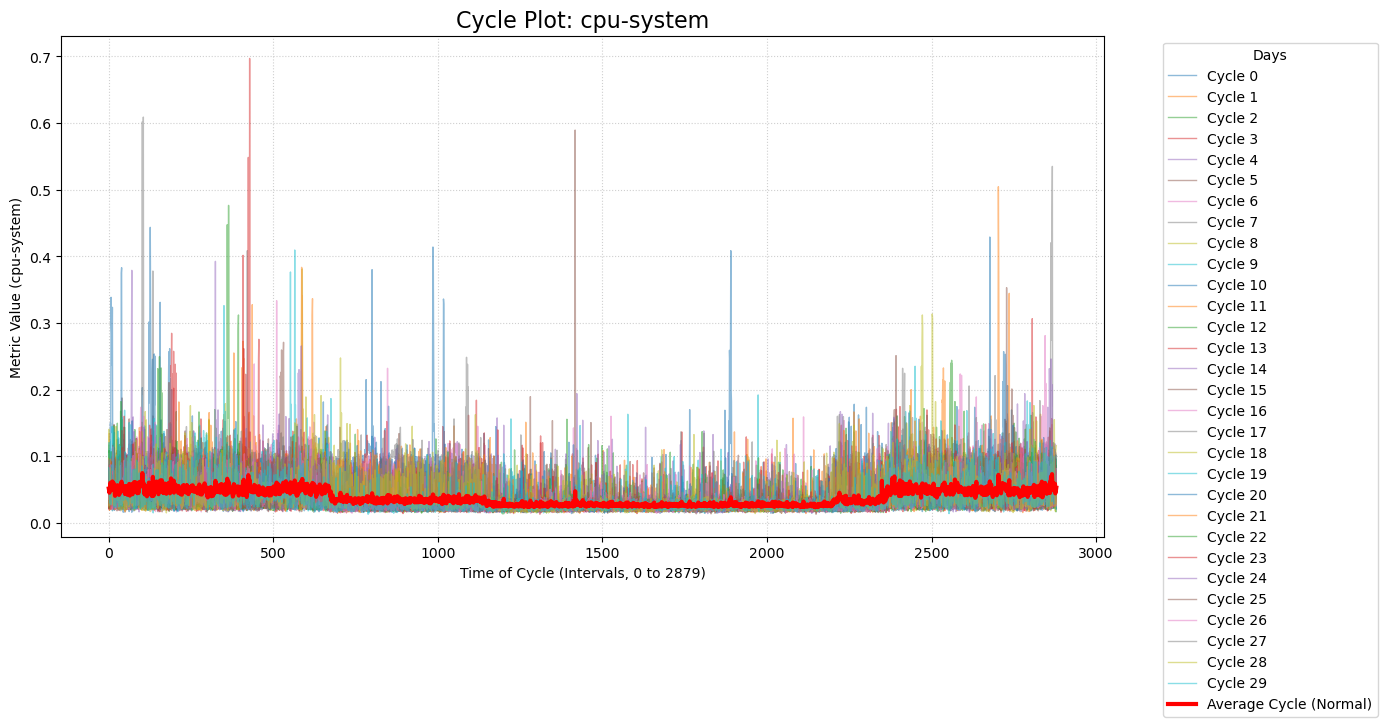

In [11]:
plot_cycle_comparison(df_initial, 
                      target_metric='cpu-system',
                      period_samples=PERIOD_DAILY, 
                      days_to_plot=30, 
                      plot_mean_cycle=True)


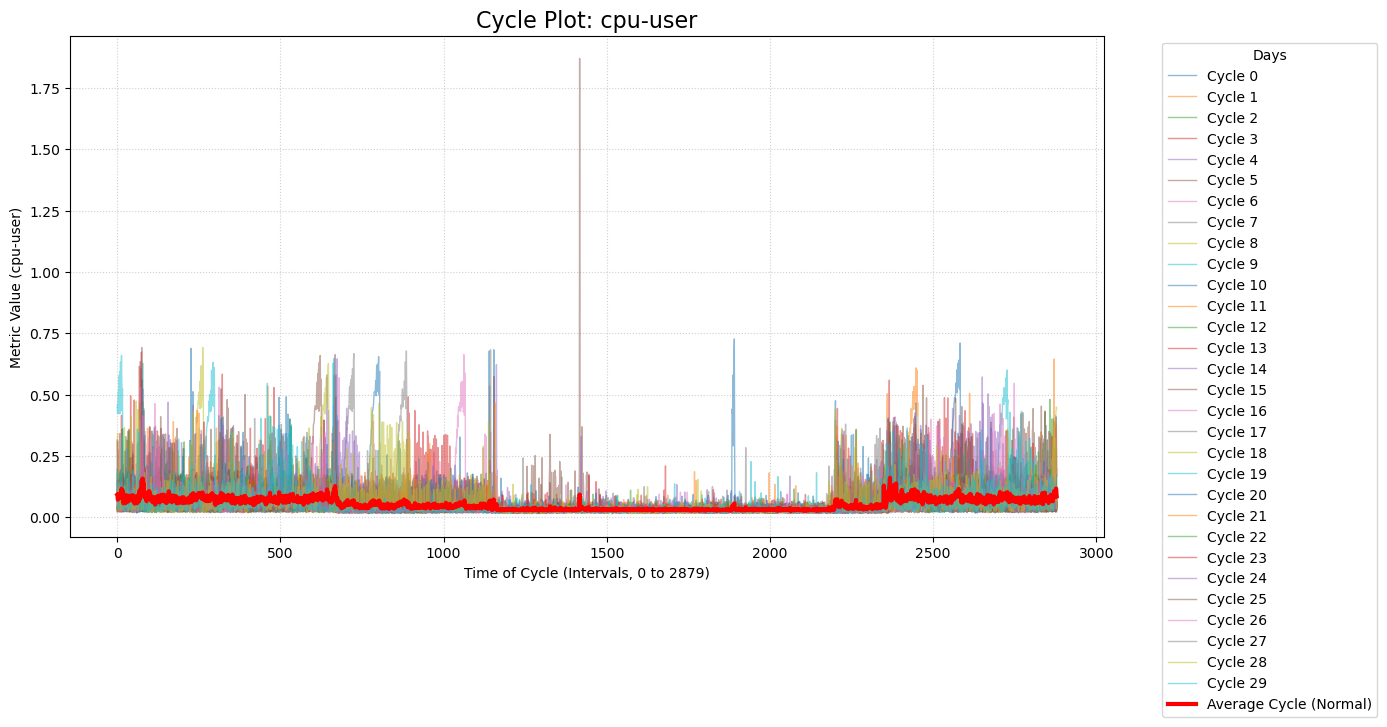

In [12]:
plot_cycle_comparison(df_initial, 
                      target_metric='cpu-user',
                      period_samples=PERIOD_DAILY, 
                      days_to_plot=30, 
                      plot_mean_cycle=True)


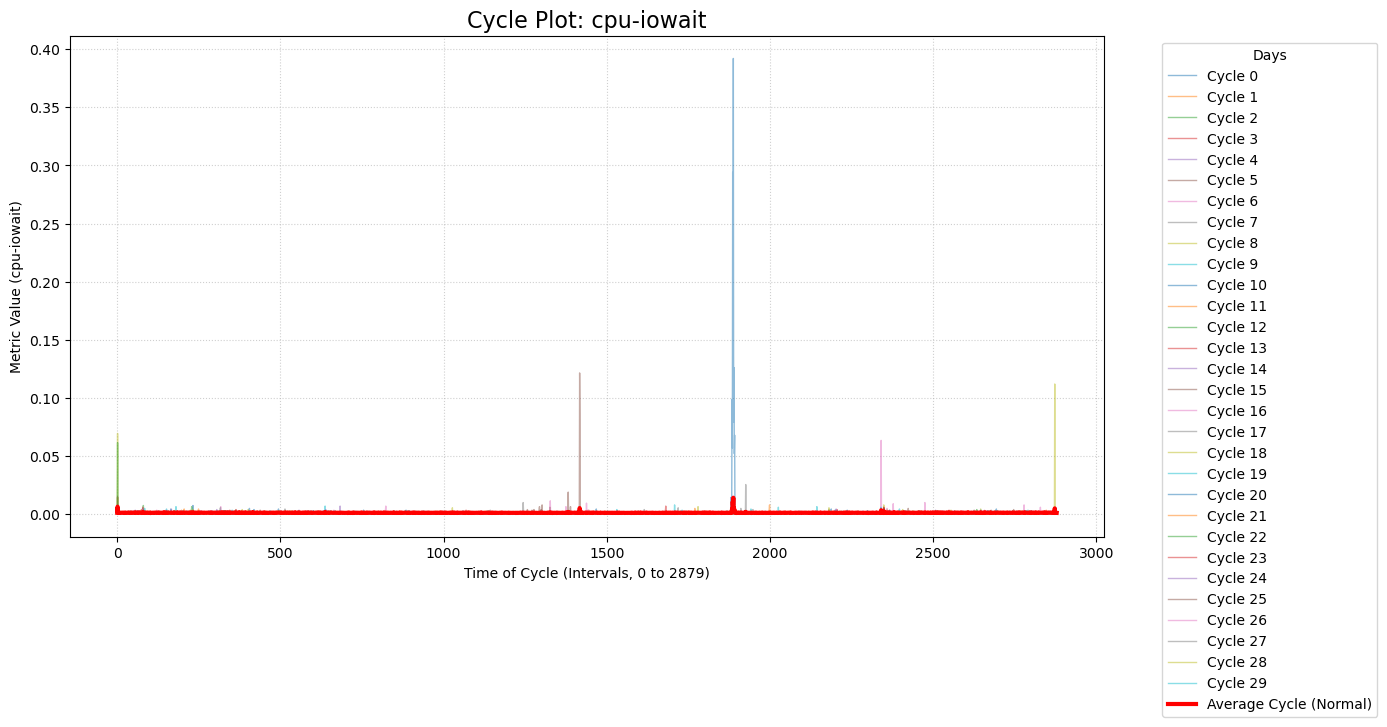

In [13]:
plot_cycle_comparison(df_initial, 
                      target_metric='cpu-iowait',
                      period_samples=PERIOD_DAILY, 
                      days_to_plot=30, 
                      plot_mean_cycle=True)

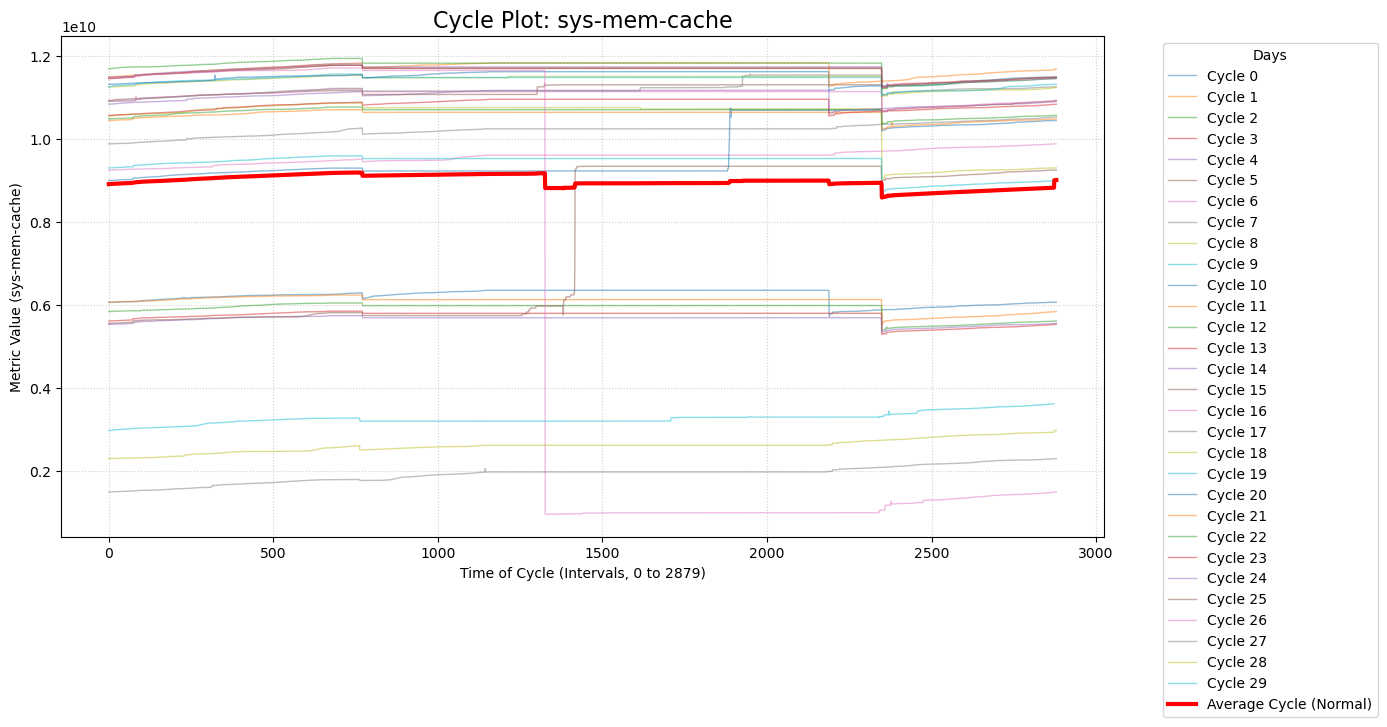

In [14]:
plot_cycle_comparison(df_initial, 
                      target_metric='sys-mem-cache',
                      period_samples=PERIOD_DAILY, 
                      days_to_plot=30, 
                      plot_mean_cycle=True)

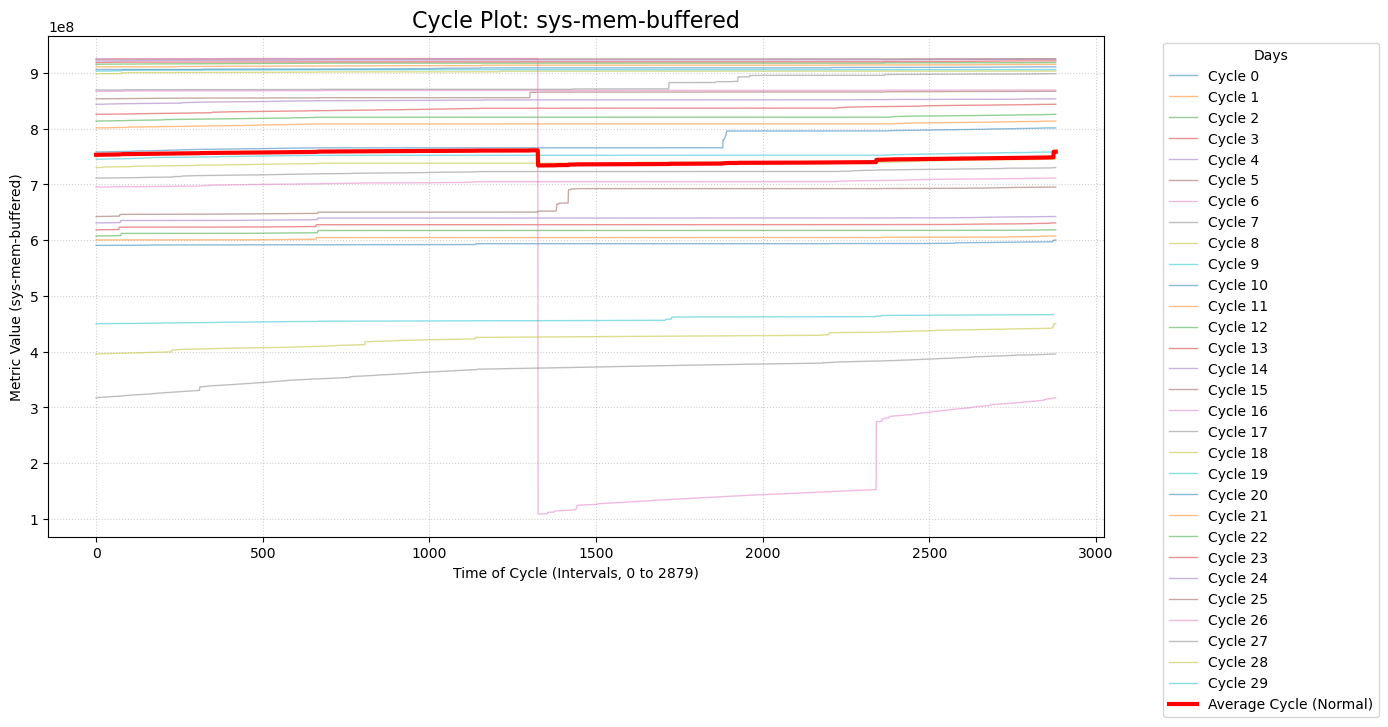

In [15]:
plot_cycle_comparison(df_initial, 
                      target_metric='sys-mem-buffered',
                      period_samples=PERIOD_DAILY, 
                      days_to_plot=30, 
                      plot_mean_cycle=True)


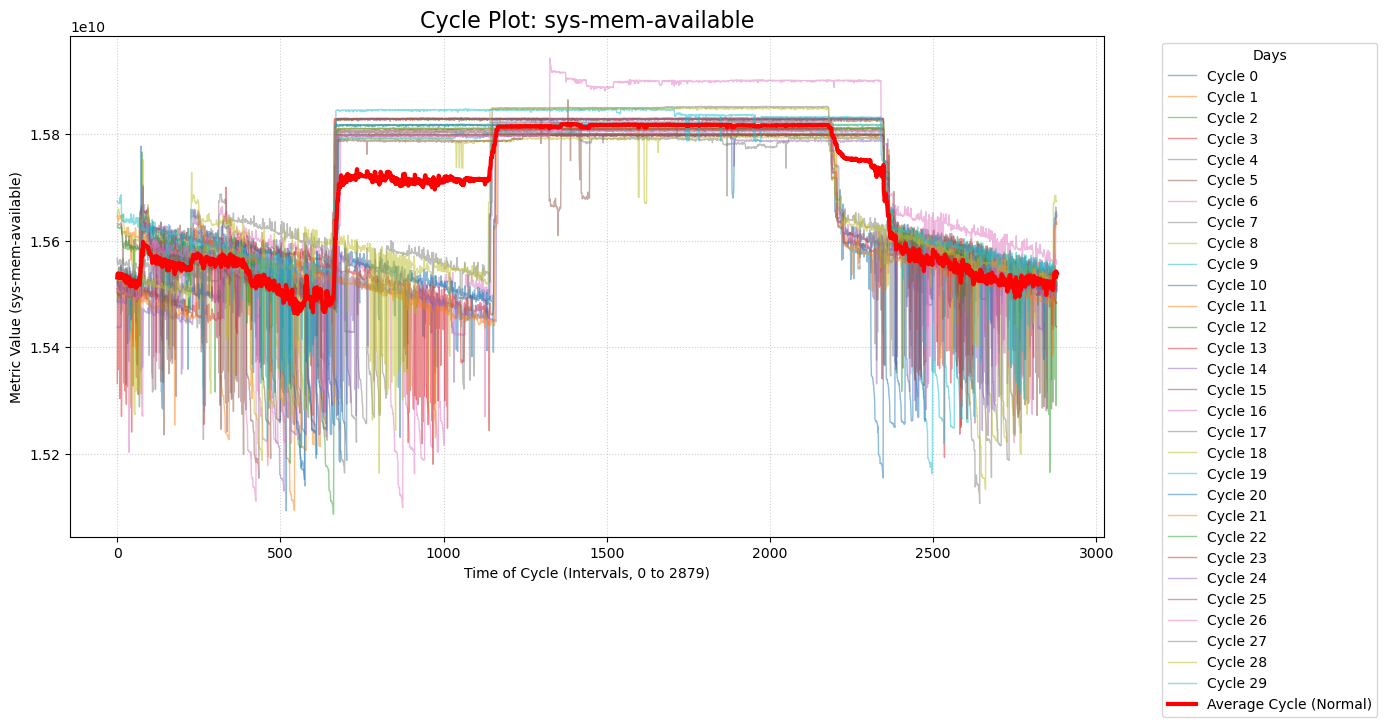

In [16]:
plot_cycle_comparison(df_initial, 
                      target_metric='sys-mem-available', 
                      period_samples=PERIOD_DAILY, 
                      days_to_plot=30, 
                      plot_mean_cycle=True)

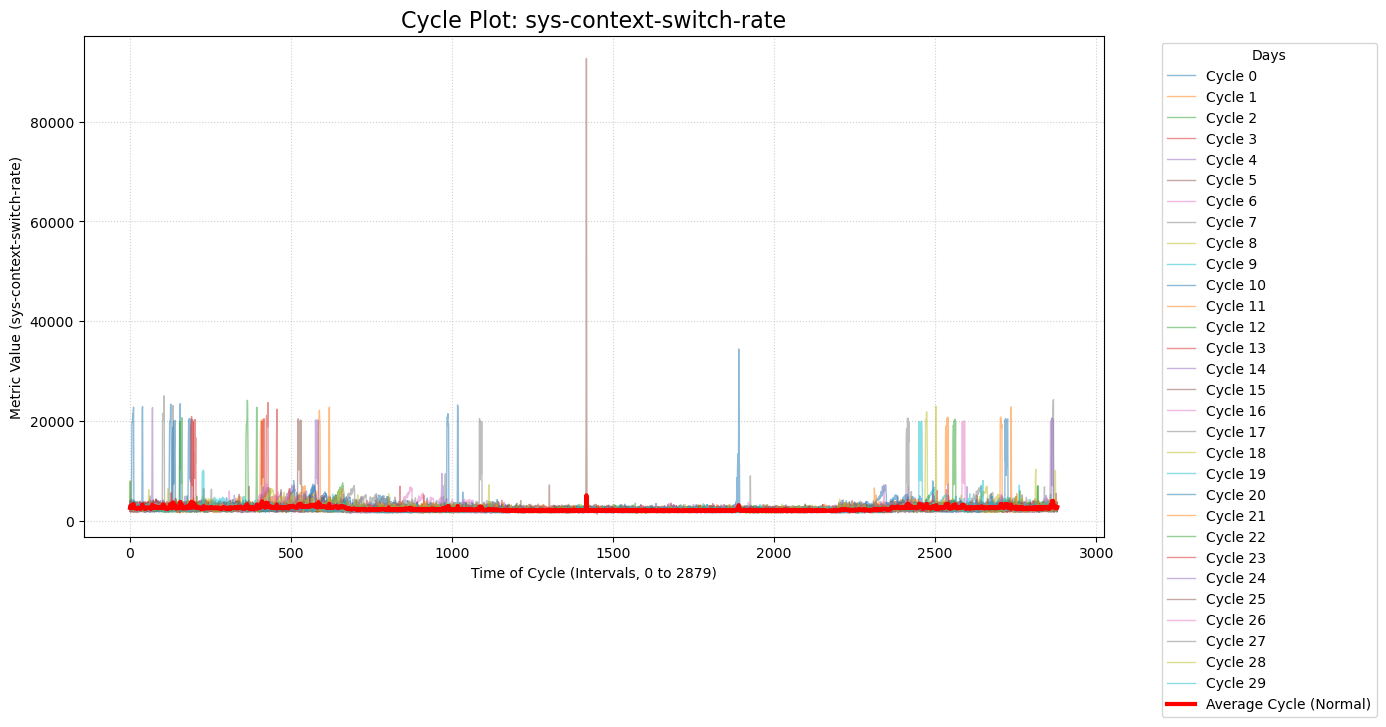

In [17]:
plot_cycle_comparison(df_initial, 
                      target_metric='sys-context-switch-rate', 
                      period_samples=PERIOD_DAILY, 
                      days_to_plot=30, 
                      plot_mean_cycle=True)


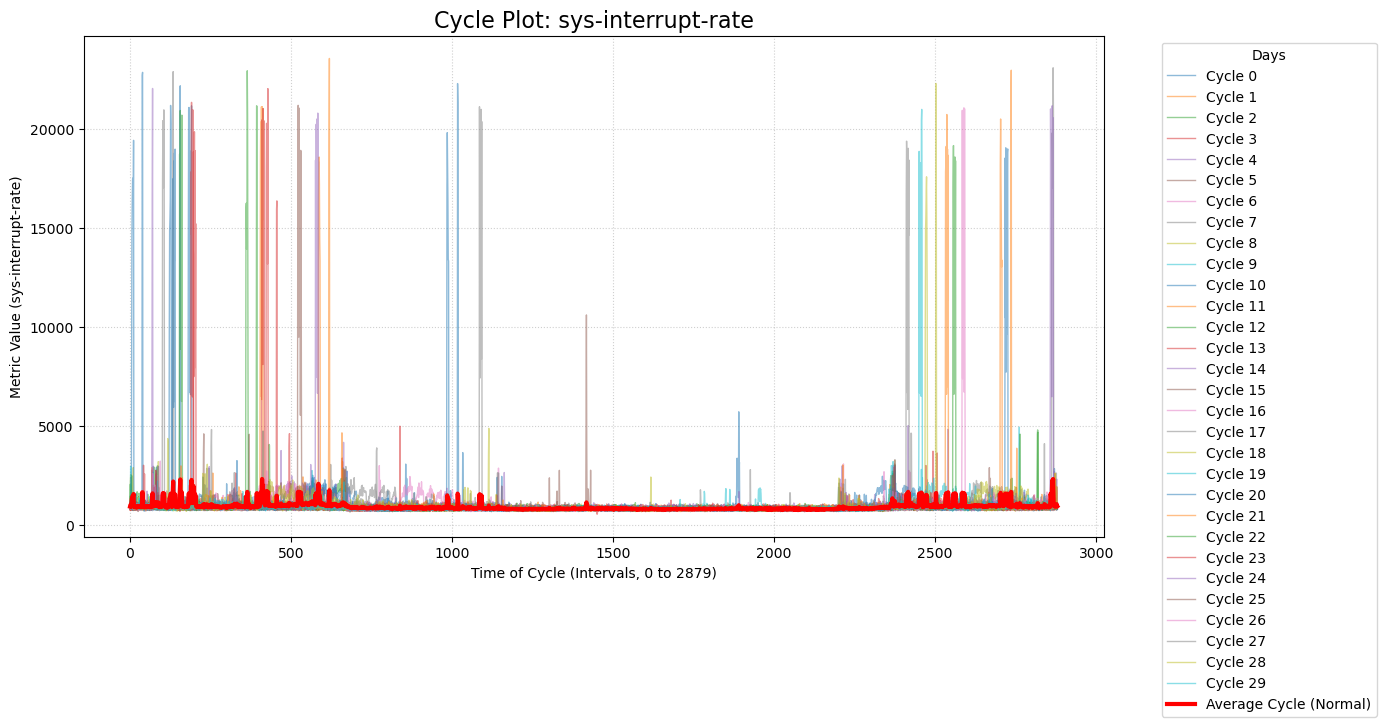

In [18]:
plot_cycle_comparison(df_initial, 
                      target_metric= 'sys-interrupt-rate', 
                      period_samples=PERIOD_DAILY, 
                      days_to_plot=30, 
                      plot_mean_cycle=True)


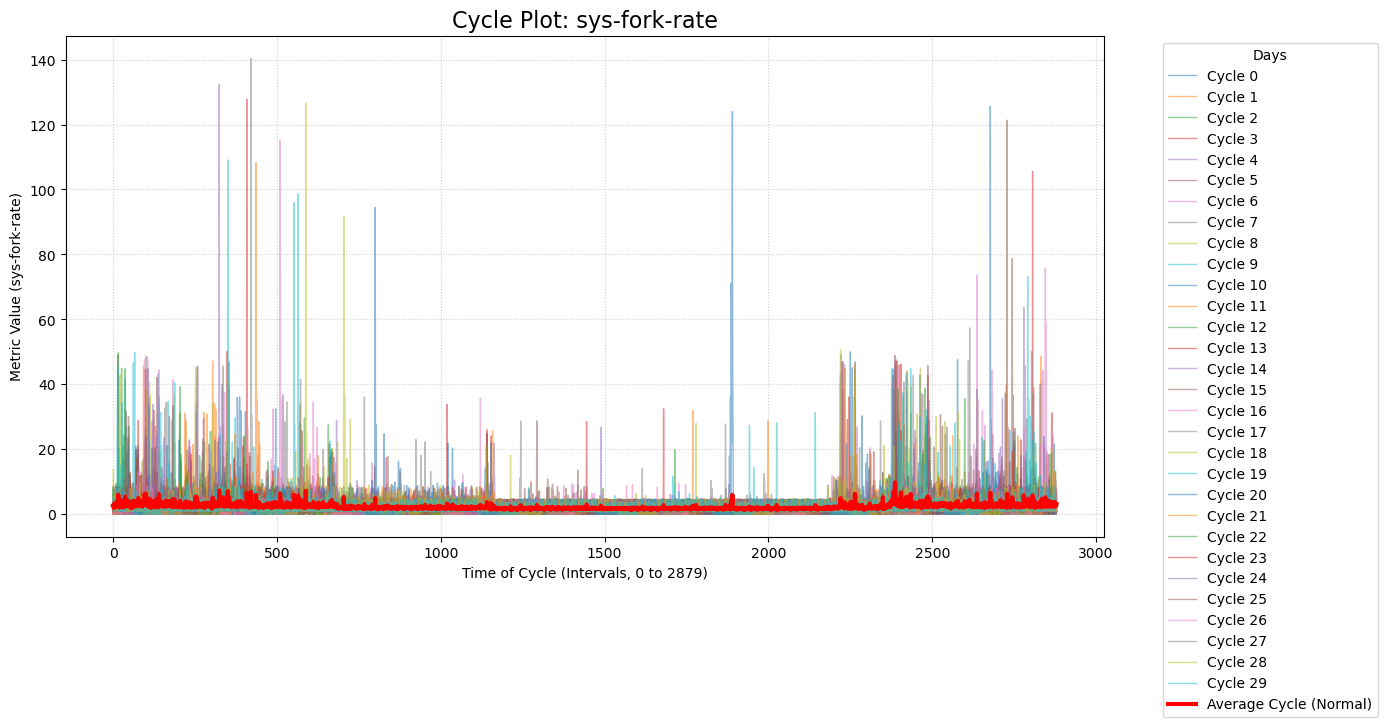

In [19]:
plot_cycle_comparison(df_initial, 
                      target_metric='sys-fork-rate', 
                      period_samples=PERIOD_DAILY, 
                      days_to_plot=30, 
                      plot_mean_cycle=True)


# Seasonal decomposition

In [20]:
decompose_results = {}
df_residuals = pd.DataFrame(index=df.index)

for metric in METRIC_NAMES:
    if metric not in df.columns:
        continue
    
    series = df[metric].dropna()
    
    res = seasonal_decompose(series, model='additive', period=PERIOD_DAILY, extrapolate_trend='freq')
    
    df_residuals[metric] = res.resid
    decompose_results[metric] = res

df_residuals['timestamp'] = df['timestamp'].values

In [21]:
df_residuals.to_csv("train_residuals.csv")

In [22]:
joblib.dump(decompose_results, "decompose_results_objects.pkl")

['decompose_results_objects.pkl']

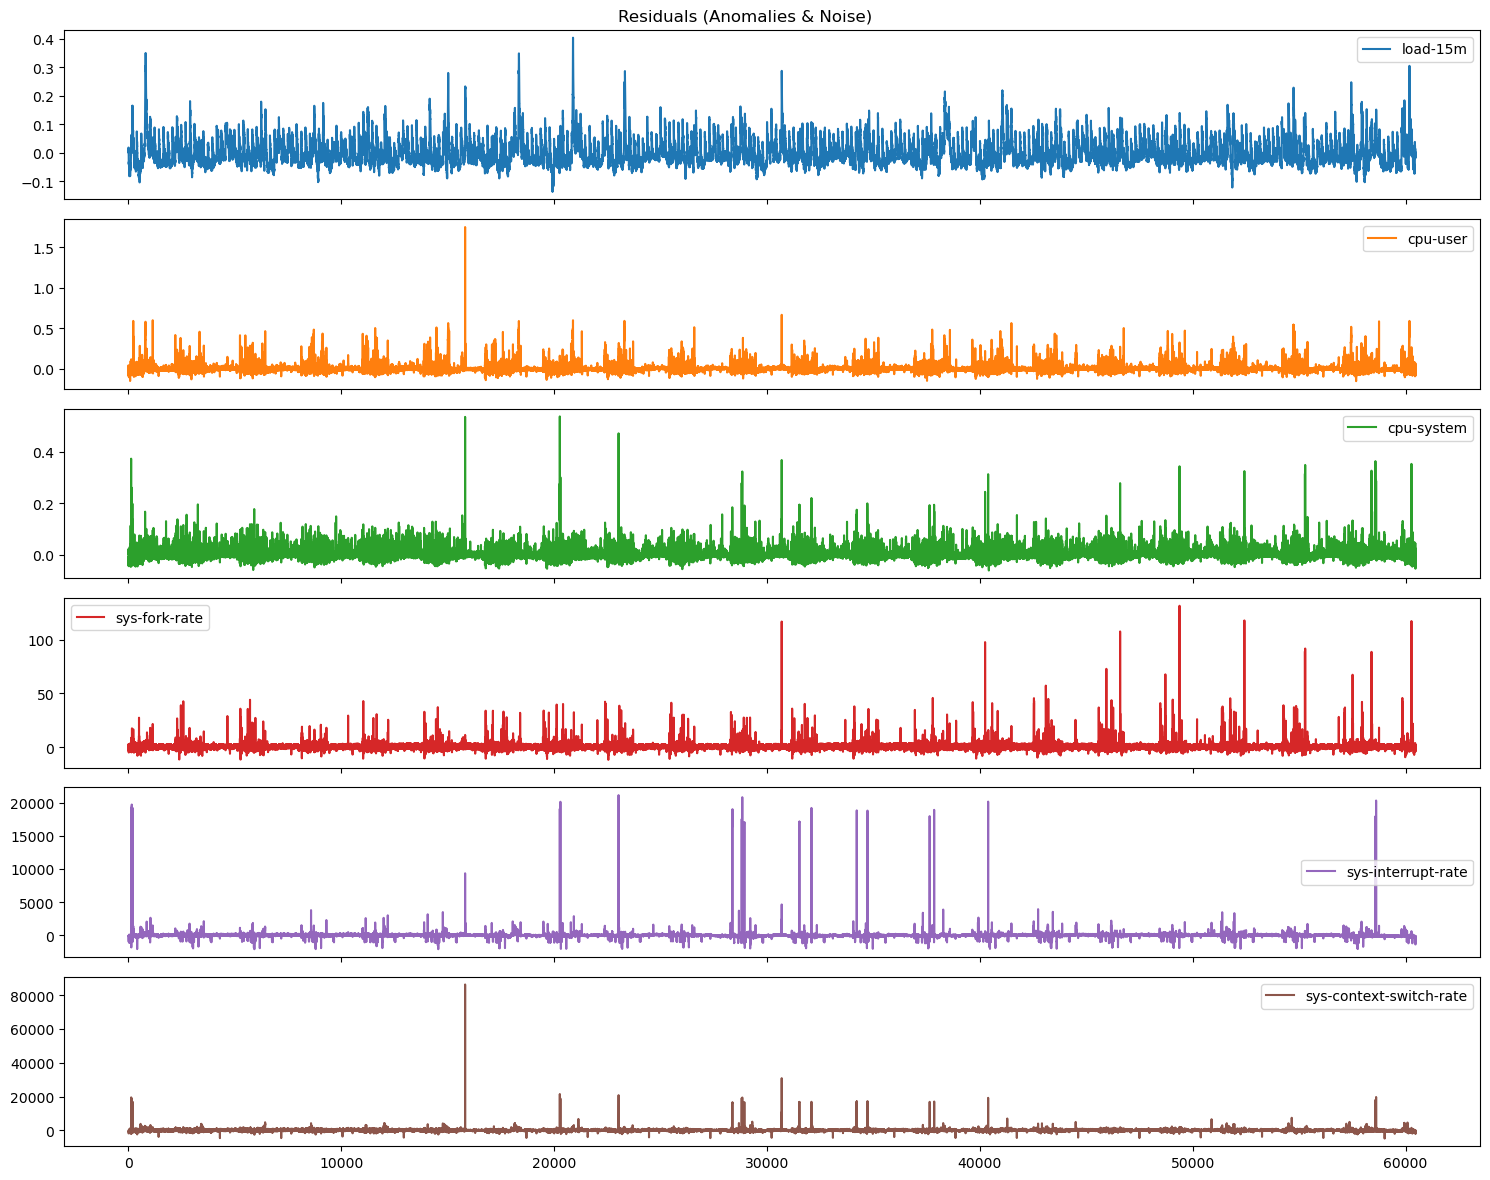

In [23]:
df_residuals[METRIC_NAMES].plot(
    subplots=True, 
    figsize=(15, 12), 
    title="Residuals (Anomalies & Noise)")

plt.tight_layout() 
plt.show()